In [1]:
import optuna
import plotly
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime

# from optuna.visualization import plot_contour
# from optuna.visualization import plot_edf
# from optuna.visualization import plot_intermediate_values
# from optuna.visualization import plot_optimization_history
# from optuna.visualization import plot_parallel_coordinate
# from optuna.visualization import plot_param_importances
# from optuna.visualization import plot_slice
print(plotly.__version__)  

5.18.0


In [2]:
import glob
import os

directory_path = 'database'
# CB_pattern = f"{directory_path}/2211_CodeBERT_*_evals9_samples*.db"
# GCB_pattern = f"{directory_path}/2211_GraphCodeBERT_*_evals9_samples*.db"
CB_pattern = f"{directory_path}/2211_CodeBERT_f1_*_evals9_samples*.db"
GCB_pattern = f"{directory_path}/2211_GraphCodeBERT_f1_*_evals9_samples*.db"


study_names = [os.path.basename(x)[:-3] for x in glob.glob(CB_pattern) if "loss_loss" not in x and "f1_f1" not in x]
CB_study_names = sorted(study_names)
print(CB_study_names)
# for filepath in glob.glob(pattern):
#     filename = os.path.basename(filepath)
#     print(filename)
    
study_names = [os.path.basename(x)[:-3] for x in glob.glob(GCB_pattern) if "loss_loss" not in x and "f1_f1" not in x]
GCB_study_names = sorted(study_names)
print(GCB_study_names)

['2211_CodeBERT_f1_CE_max_evals9_samples40960', '2211_CodeBERT_f1_FL_max_evals9_samples40960', '2211_CodeBERT_f1_default_max_evals9_samples40960', '2211_CodeBERT_f1_descendants_max_evals9_samples40960', '2211_CodeBERT_f1_equalize_max_evals9_samples40960', '2211_CodeBERT_f1_reachable_leaf_nodes_max_evals9_samples40960']
['2211_GraphCodeBERT_f1_CE_max_evals9_samples40960', '2211_GraphCodeBERT_f1_FL_max_evals9_samples40960', '2211_GraphCodeBERT_f1_default_max_evals9_samples40960', '2211_GraphCodeBERT_f1_descendants_max_evals9_samples40960', '2211_GraphCodeBERT_f1_equalize_max_evals9_samples40960', '2211_GraphCodeBERT_f1_reachable_leaf_nodes_max_evals9_samples40960']


In [3]:
def get_studies(study_names):
    studies = []
    for study_name in study_names:
        db_url = f"sqlite:///database/{study_name}.db"
        study = optuna.load_study(study_name=study_name, storage=db_url)
        studies.append(study)
    return studies

CB_studies = get_studies(CB_study_names)
GCB_studies = get_studies(GCB_study_names)

In [4]:
from PIL import Image
def get_combined_figure(study_names, studies, model_name='GraphCodeBERT', plot_function='plot_slice'):
    
    def extract_part_of_study_name(full_study_name, start_text, end_text):
        # Split the string by the start_text and take the second part
        after_start = full_study_name.split(start_text)[-1]

        # Split the new string by the end_text and take the first part
        desired_part = after_start.split(end_text)[0]
        return desired_part

    def save_individual_plots(study_names, studies):
        for i, (study_name, study) in enumerate(zip(study_names, studies)):
            if plot_function == 'plot_slice':
                fig = optuna.visualization.matplotlib.plot_slice(study)
            else:
                fig = optuna.visualization.matplotlib.plot_optimization_history(study)
                
            desired_part = extract_part_of_study_name(study_name, f"2211_{model_name}_f1_", "_max_evals9_samples40960")

            if desired_part == 'CE':
                title = 'Cross_Entropy_Loss'
            elif desired_part == 'FL':
                title = 'Focal_Loss'
            else:
                title = 'Loss_Weight_'+desired_part
            print(title)
            plt.title(f"{title}")
            if plot_function == 'plot_slice':
                plt.savefig(f"figures/HPO/plot_slice_{study_name}.png")
            else:
                plt.savefig(f"figures/HPO/optimization_history_{study_name}.png")
            plt.close()

    # Example usage
    save_individual_plots(study_names, studies)

    def combine_plots_into_one(study_names):
        if plot_function == 'plot_slice':
            images = [Image.open(f"figures/HPO/plot_slice_{name}.png") for name in study_names]
        else:
            images = [Image.open(f"figures/HPO/optimization_history_{name}.png") for name in study_names]

        # Assuming all images have the same size
        width, height = images[0].size
       
        # Create a new image to combine the plots
        if plot_function == 'plot_slice':
            combined_image = Image.new('RGB', (width * 1, height * 3))
        else:
            combined_image = Image.new('RGB', (width * 2, height * 3))

        # Paste each image into the combined image
        combined_images = []
        if plot_function == 'plot_slice':
            for i, image in enumerate(images):
                x = 0 
                y = (i%3) * height #y = i * height
#                 print(x,y,image)
                combined_image.paste(image, (x, y))
#                 plt.imshow(combined_image)
#                 plt.show()
                if (i%3) == 2:
                    combined_images.append(combined_image)
                    print(f"i={i} combined_images.append(combined_image) {combined_images}")
                    combined_image = Image.new('RGB', (width * 1, height * 3))
        else:
            for i, image in enumerate(images):
                x = (i % 2) * width
                y = (i // 2) * height
                combined_image.paste(image, (x, y))
        print("len combined_images:",len(combined_images))
        # Save the combined image
        if plot_function == 'plot_slice':
            for i, combined_image in enumerate(combined_images):
                combined_image.save(f'figures/HPO/{model_name}_combined_plot_slice_{i}.png')
        else:
            combined_image.save(f'figures/HPO/{model_name}_combined_optimization_history.png')

    # Example usage
    combine_plots_into_one(study_names)


In [5]:
get_combined_figure(GCB_study_names, GCB_studies, model_name='GraphCodeBERT', plot_function='plot_slice')
get_combined_figure(CB_study_names, CB_studies, model_name='CodeBERT', plot_function='plot_slice')
get_combined_figure(GCB_study_names, GCB_studies, model_name='GraphCodeBERT', plot_function='plot_optimization_history')
get_combined_figure(CB_study_names, CB_studies, model_name='CodeBERT', plot_function='plot_optimization_history')

/tmp/ipykernel_84936/3707405940.py:15: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)


Cross_Entropy_Loss


/tmp/ipykernel_84936/3707405940.py:15: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)


Focal_Loss


/tmp/ipykernel_84936/3707405940.py:15: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)


Loss_Weight_default


/tmp/ipykernel_84936/3707405940.py:15: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)


Loss_Weight_descendants


/tmp/ipykernel_84936/3707405940.py:15: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)


Loss_Weight_equalize


/tmp/ipykernel_84936/3707405940.py:15: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)


Loss_Weight_reachable_leaf_nodes
i=2 combined_images.append(combined_image) [<PIL.Image.Image image mode=RGB size=1280x1440 at 0x7F6AC92CDD20>]
i=5 combined_images.append(combined_image) [<PIL.Image.Image image mode=RGB size=1280x1440 at 0x7F6AC92CDD20>, <PIL.Image.Image image mode=RGB size=1280x1440 at 0x7F6AC606C9D0>]
len combined_images: 2


/tmp/ipykernel_84936/3707405940.py:15: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)


Cross_Entropy_Loss


/tmp/ipykernel_84936/3707405940.py:15: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)


Focal_Loss


/tmp/ipykernel_84936/3707405940.py:15: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)


Loss_Weight_default


/tmp/ipykernel_84936/3707405940.py:15: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)


Loss_Weight_descendants


/tmp/ipykernel_84936/3707405940.py:15: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)


Loss_Weight_equalize


/tmp/ipykernel_84936/3707405940.py:15: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)


Loss_Weight_reachable_leaf_nodes
i=2 combined_images.append(combined_image) [<PIL.Image.Image image mode=RGB size=1280x1440 at 0x7F6AC5F75330>]
i=5 combined_images.append(combined_image) [<PIL.Image.Image image mode=RGB size=1280x1440 at 0x7F6AC5F75330>, <PIL.Image.Image image mode=RGB size=1280x1440 at 0x7F6AC4697850>]
len combined_images: 2


/tmp/ipykernel_84936/3707405940.py:17: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


Cross_Entropy_Loss


/tmp/ipykernel_84936/3707405940.py:17: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


Focal_Loss


/tmp/ipykernel_84936/3707405940.py:17: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


Loss_Weight_default


/tmp/ipykernel_84936/3707405940.py:17: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


Loss_Weight_descendants


/tmp/ipykernel_84936/3707405940.py:17: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


Loss_Weight_equalize


/tmp/ipykernel_84936/3707405940.py:17: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


Loss_Weight_reachable_leaf_nodes
len combined_images: 0
Cross_Entropy_Loss


/tmp/ipykernel_84936/3707405940.py:17: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)
/tmp/ipykernel_84936/3707405940.py:17: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


Focal_Loss


/tmp/ipykernel_84936/3707405940.py:17: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


Loss_Weight_default


/tmp/ipykernel_84936/3707405940.py:17: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


Loss_Weight_descendants


/tmp/ipykernel_84936/3707405940.py:17: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


Loss_Weight_equalize


/tmp/ipykernel_84936/3707405940.py:17: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


Loss_Weight_reachable_leaf_nodes
len combined_images: 0


In [6]:
# from PIL import Image

# def extract_part_of_study_name(full_study_name, start_text, end_text):
#     # Split the string by the start_text and take the second part
#     after_start = full_study_name.split(start_text)[-1]
    
#     # Split the new string by the end_text and take the first part
#     desired_part = after_start.split(end_text)[0]
#     return desired_part

# def save_individual_plots(study_names, studies):
#     for i, (study_name, study) in enumerate(zip(study_names, studies)):
# #         fig = optuna.visualization.matplotlib.plot_optimization_history(study)
#         fig = optuna.visualization.matplotlib.plot_slice(study)
#         desired_part = extract_part_of_study_name(study_name, "2211_GraphCodeBERT_f1_", "_max_evals9_samples40960")
        
#         if desired_part == 'CE':
#             title = 'Cross Entropy Loss'
#         elif desired_part == 'FL':
#             title = 'Focal Loss'
#         else:
#             title = 'Loss Weight: '+desired_part
#         print(title)
#         plt.title(f"{title}")
#         plt.savefig(f"figures/plot_slice_{study_name}.png")
# #         plt.savefig(f"figures/optimization_history_{study_name}.png")
#         plt.close()

# # Example usage
# save_individual_plots(GCB_study_names, GCB_studies)

# def combine_plots_into_one(study_names):
#     images = [Image.open(f"figures/plot_slice_{name}.png") for name in study_names]
# #     images = [Image.open(f"figures/optimization_history_{name}.png") for name in study_names]

#     # Assuming all images have the same size
#     width, height = images[0].size

#     # Create a new image to combine the plots
# #     combined_image = Image.new('RGB', (width * 3, height * 2))
#     combined_image = Image.new('RGB', (width * 1, height * 6))

#     # Paste each image into the combined image
#     for i, image in enumerate(images):
#         x = (i % 2) * width
#         y = (i // 2) * height
#         combined_image.paste(image, (x, y))

#     # Save the combined image
#     combined_image.save('figures/GCB_combined_plot_slice.png')
# #     combined_image.save('figures/CB_combined_optimization_history.png')

# # Example usage
# combine_plots_into_one(GCB_study_names)


In [7]:
# import glob
# import os

# directory_path = 'database'
# CB_pattern = f"{directory_path}/2211_CodeBERT_f1_*_evals9_samples*.db"
# GCB_pattern = f"{directory_path}/2211_GraphCodeBERT_f1_*_evals9_samples*.db"

# study_names = [os.path.basename(x)[:-3] for x in glob.glob(CB_pattern) if "loss_loss" not in x and "f1_f1" not in x]
# CB_study_names = sorted(study_names)
# print(CB_study_names)
# # for filepath in glob.glob(pattern):
# #     filename = os.path.basename(filepath)
# #     print(filename)
    
# study_names = [os.path.basename(x)[:-3] for x in glob.glob(GCB_pattern) if "loss_loss" not in x and "f1_f1" not in x]
# GCB_study_names = sorted(study_names)
# print(GCB_study_names)
# def get_studies(study_names):
#     studies = []
#     for study_name in study_names:
#         db_url = f"sqlite:///database/{study_name}.db"
#         study = optuna.load_study(study_name=study_name, storage=db_url)
#         studies.append(study)
#     return studies

# CB_studies = get_studies(CB_study_names)
# GCB_studies = get_studies(GCB_study_names)
# def plot_optimization_history(study_names, studies):
#     # Create a figure with 3x2 subplots
#     n_rows = 3
#     n_cols = 2
#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
#     axes = axes.flatten()

#     for i, (study_name, study) in enumerate(zip(study_names, studies)):
#         # Use the current axis for the Optuna plot
#         ax = axes[i]
#         fig = optuna.visualization.matplotlib.plot_optimization_history(study)
#         ax_figure = plt.gcf()
#         ax.clear()
#         for artist in ax_figure.axes[0].get_children():
#             artist.remove()
#             artist.figure = fig
#             ax._add_text(artist)
#         ax.set_title(f"{study_name} Optimization History")

#     # Adjust the layout and add a main title
#     plt.tight_layout()
#     plt.suptitle("Optimization History for CodeBERT")

#     # Save the figure
#     plt.savefig("figures/CB_optimization_history.png")

#     # Optionally, display the figure
#     plt.show()

# # Example usage
# # plot_optimization_history(study_names, studies)
# plot_optimization_history(CB_study_names, CB_studies)
# # plot_optimization_history(study_names, studies)

In [8]:

def plot_optimization_history(study_names, studies):
    for i, study in enumerate(studies):
        optuna.visualization.matplotlib.plot_optimization_history(study)
        plt.tight_layout()
        plt.title(f"{study_names[i]} Optimization History")
        plt.show()

        # Slice Plot
def plot_slice(study_names, studies):
    for i, study in enumerate(studies):
        optuna.visualization.matplotlib.plot_slice(study)
        plt.tight_layout()
        plt.title(f"{study_names[i]} Slice Plot")
        plt.show()

    # optuna.visualization.matplotlib.plot_slice(study)
    # plt.show()
        
def plot_param_importances(study_names, studies):
    for i, study in enumerate(studies):
        optuna.visualization.matplotlib.plot_param_importances(study)
        plt.tight_layout()
        plt.title(f"{study_names[i]} Param Importance")
        plt.show()

        # optuna.visualization.matplotlib.plot_param_importances(study)
        # plt.show()

        # sns.set_theme()
        # sns.set_style("whitegrid")
        # x = optuna.visualization.matplotlib.plot_param_importances(study_eqaulize)

        # plt.tight_layout()
        # plt.savefig('hpo_importance.png')
        # plt.show()

def plot_optimization_histories(study_names, studies):
    plt.figure(figsize=(10, 6))

    for study, name in zip(studies, study_names):
        trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
        best_values = [float('inf')] * len(trials)
        for i, trial in enumerate(sorted(trials, key=lambda x: x.number)):
            if i > 0:
                best_values[i] = min(best_values[i - 1], trial.value)
            else:
                best_values[i] = trial.value
        
        plt.plot(best_values, label=name)

    plt.title("Optimization Histories Comparison")
    plt.xlabel("Number of Trials")
    plt.ylabel("Best Objective Value")
    plt.legend()
    plt.grid()
    plt.show()


def plot_values_over_time(study_names, studies):
    plt.figure(figsize=(12, 6))
    
    for study, name in zip(studies, study_names):
        trial_timestamps = [datetime.fromtimestamp(trial.datetime_start.timestamp()) for trial in study.trials]
        trial_values = [trial.value for trial in study.trials]

        plt.plot(trial_timestamps, trial_values, marker='o', label=name)

    # Formatting the plot
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotation

    plt.title("Objective Values Over Time Across Studies")
    plt.xlabel("Time")
    plt.ylabel("Objective Value")
    plt.legend()
    plt.grid()
    plt.show()


## CodeBERT HPO Visualization

/tmp/ipykernel_84936/1396822593.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


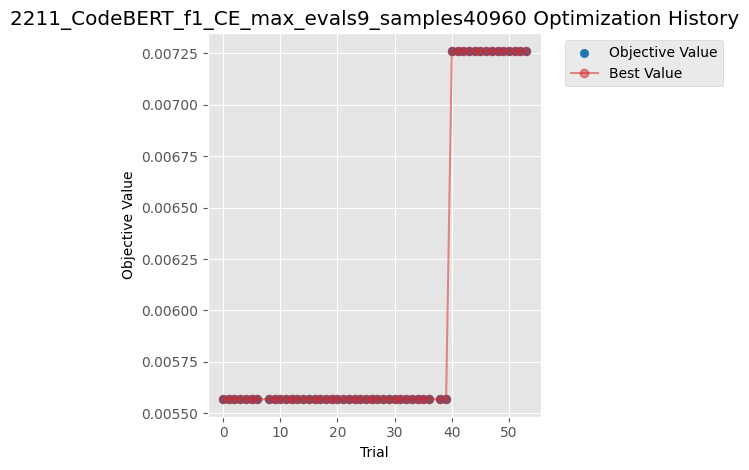

/tmp/ipykernel_84936/1396822593.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


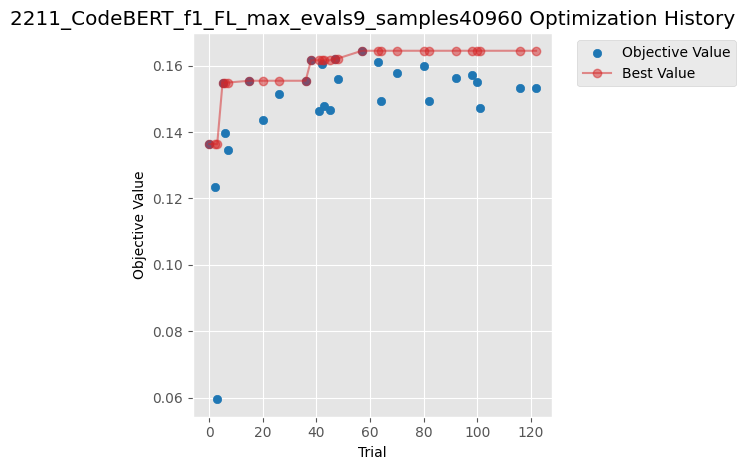

/tmp/ipykernel_84936/1396822593.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


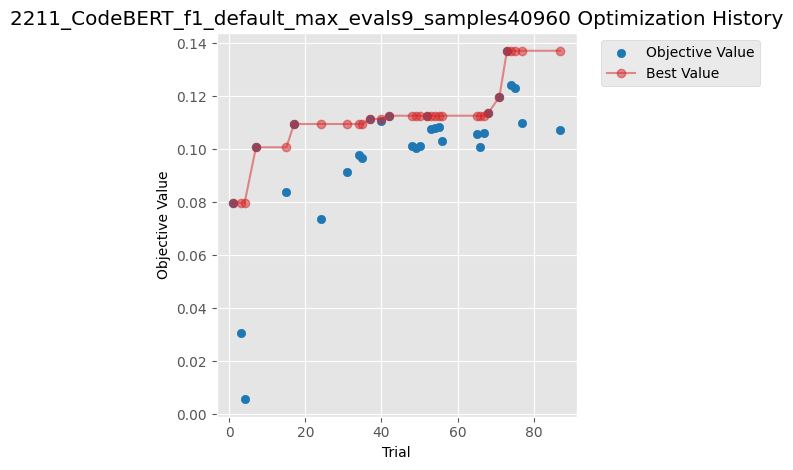

/tmp/ipykernel_84936/1396822593.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


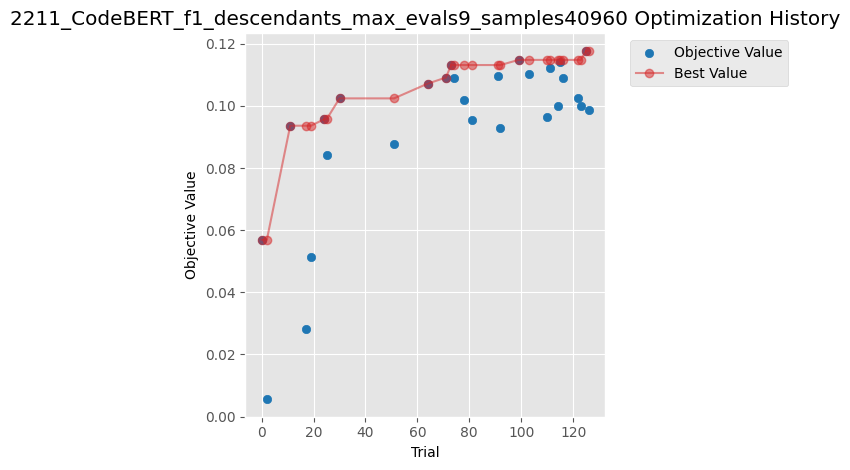

/tmp/ipykernel_84936/1396822593.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


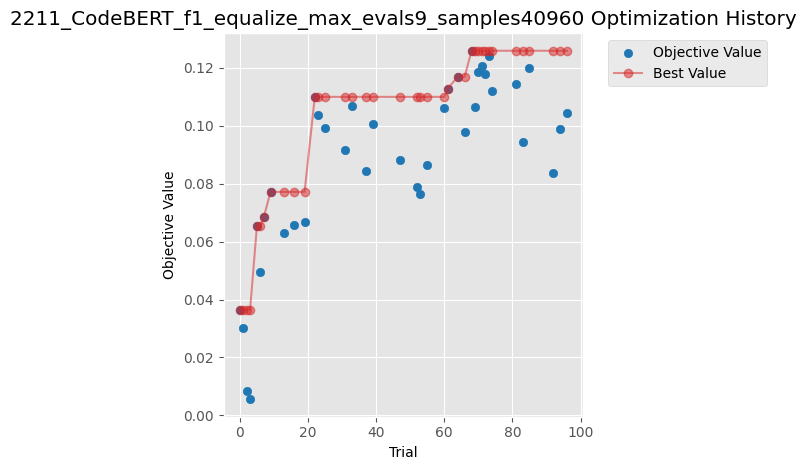

/tmp/ipykernel_84936/1396822593.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


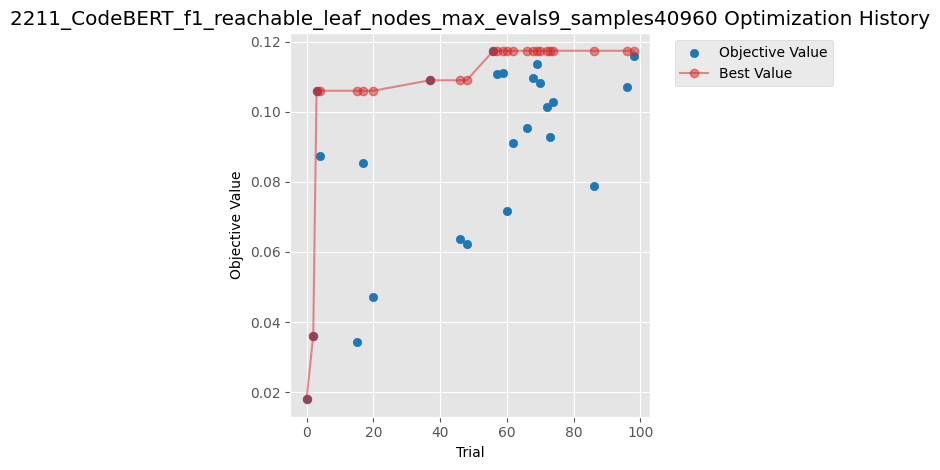

In [9]:
plot_optimization_history(CB_study_names, CB_studies)

In [10]:
# plot_param_importances(CB_study_names, CB_studies)

/tmp/ipykernel_84936/1396822593.py:11: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_84936/1396822593.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


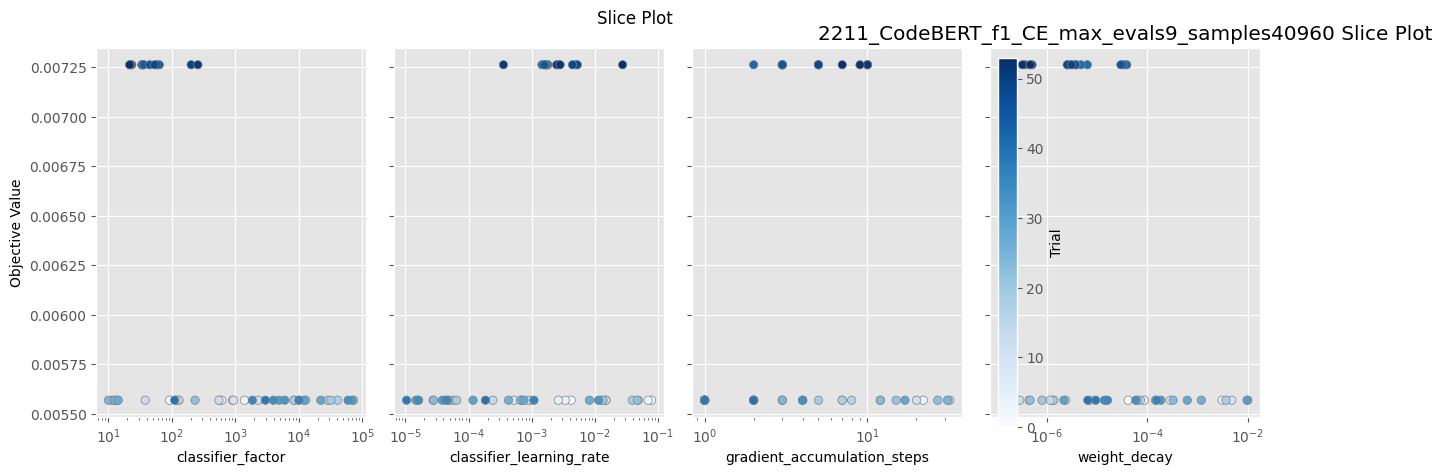

/tmp/ipykernel_84936/1396822593.py:11: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_84936/1396822593.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


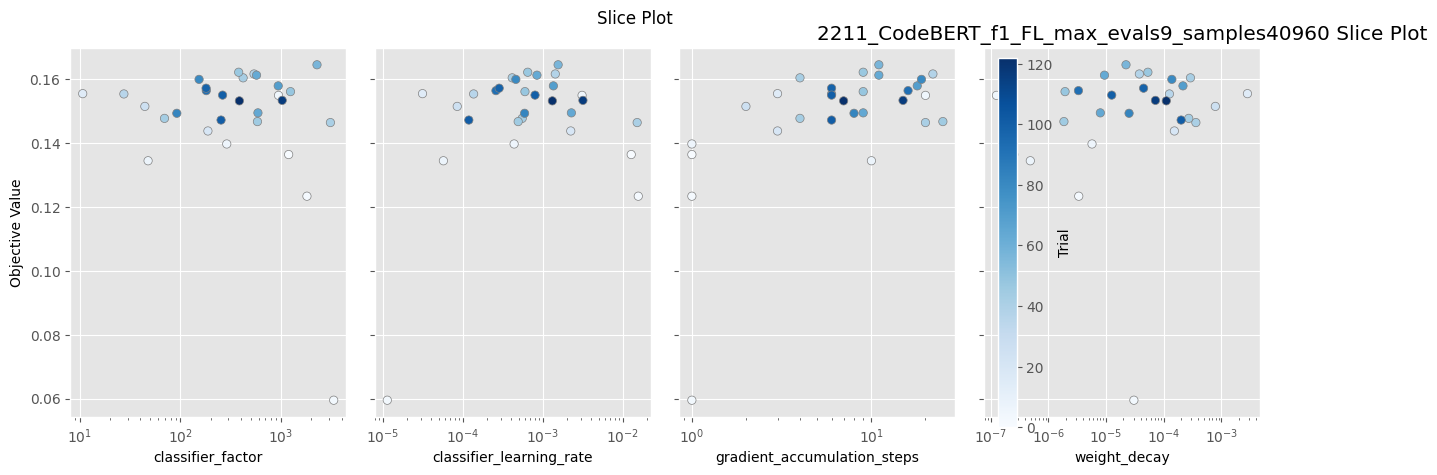

/tmp/ipykernel_84936/1396822593.py:11: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_84936/1396822593.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


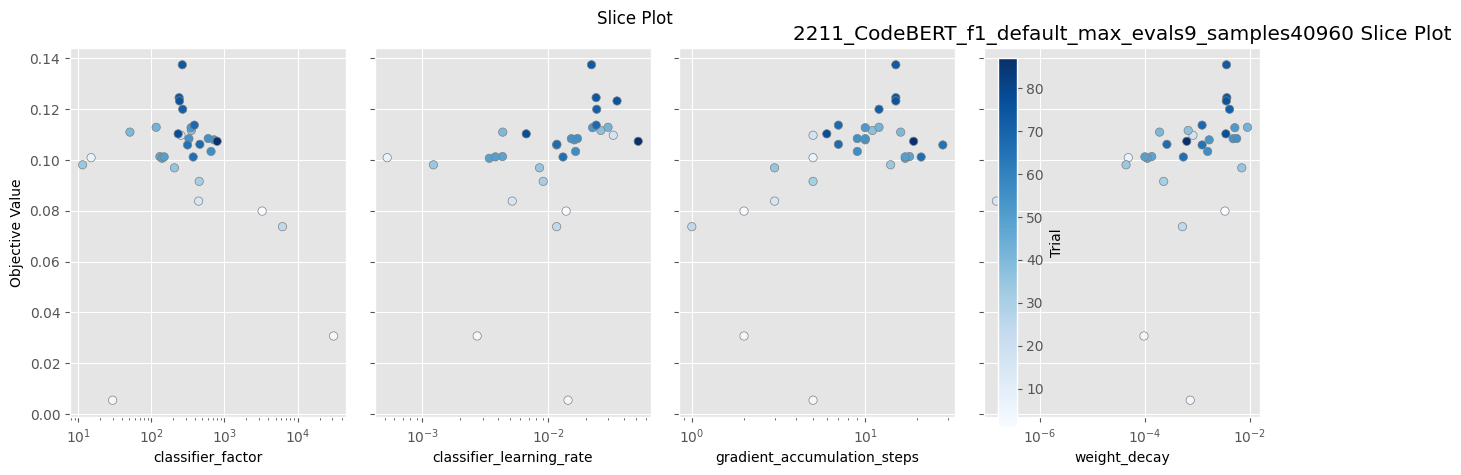

/tmp/ipykernel_84936/1396822593.py:11: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_84936/1396822593.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


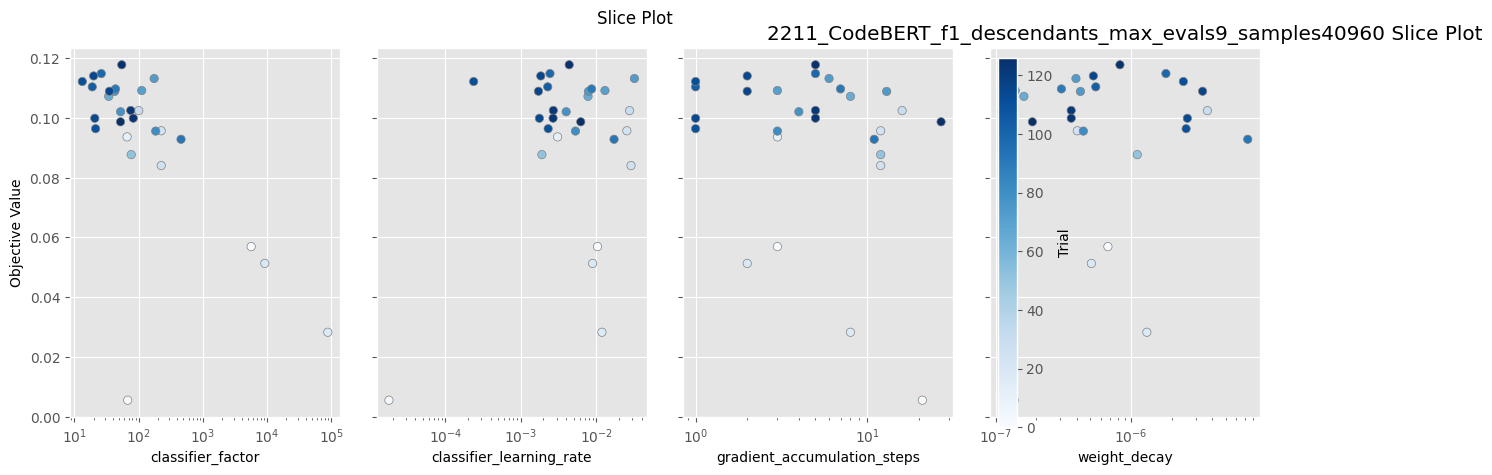

/tmp/ipykernel_84936/1396822593.py:11: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_84936/1396822593.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


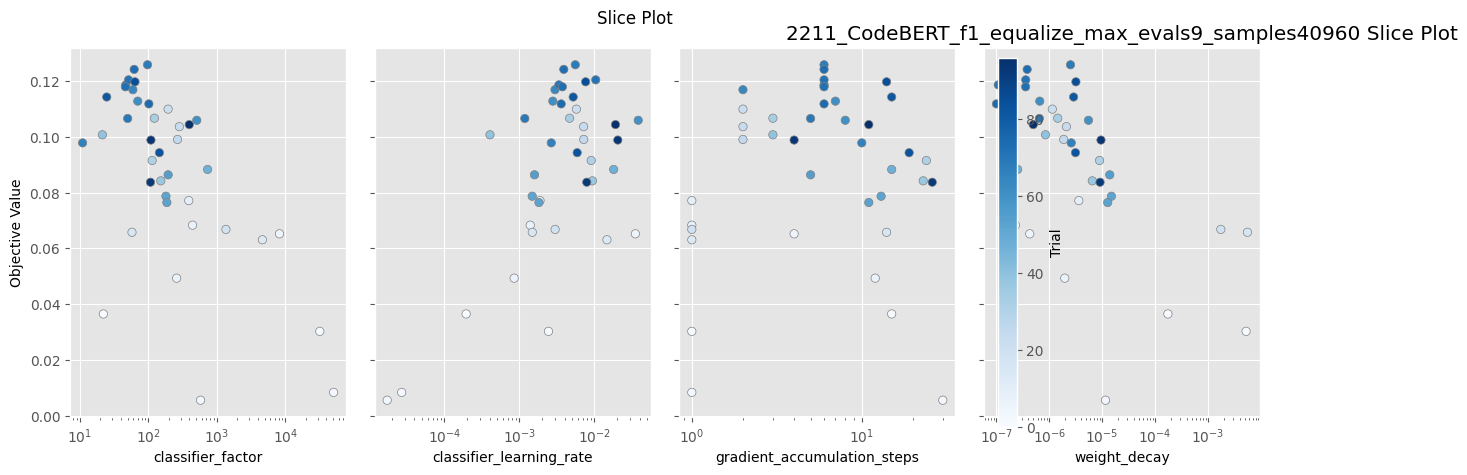

/tmp/ipykernel_84936/1396822593.py:11: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_84936/1396822593.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


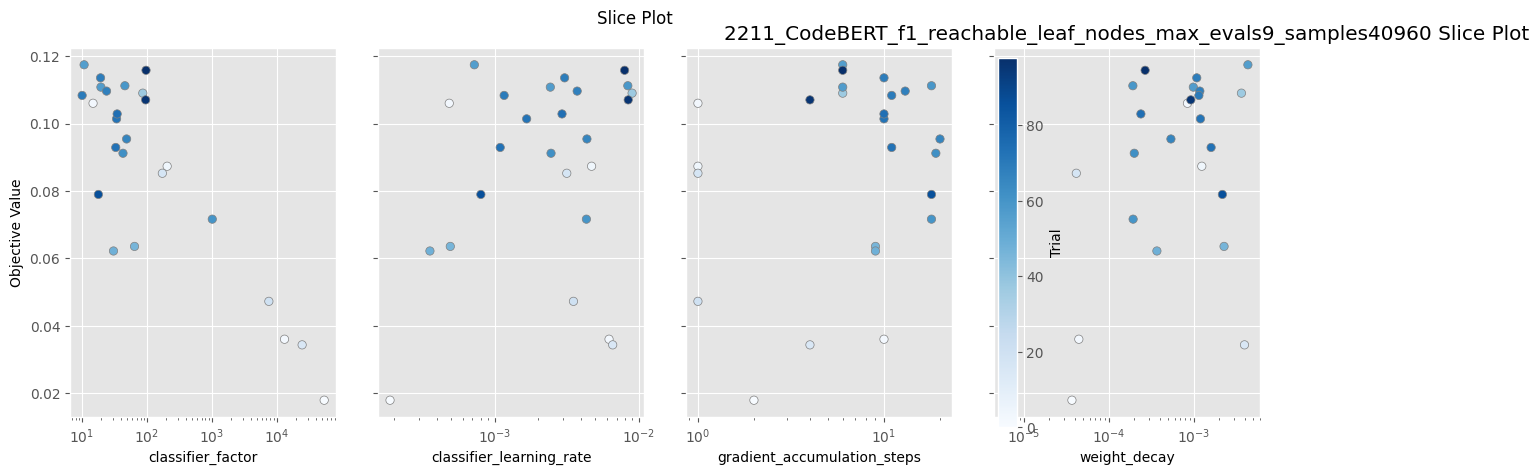

In [11]:
plot_slice(CB_study_names, CB_studies)

In [12]:
# plot_values_over_time(CB_study_names, CB_studies)

## GraphCodeBERT HPO Visualization

/tmp/ipykernel_84936/1396822593.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


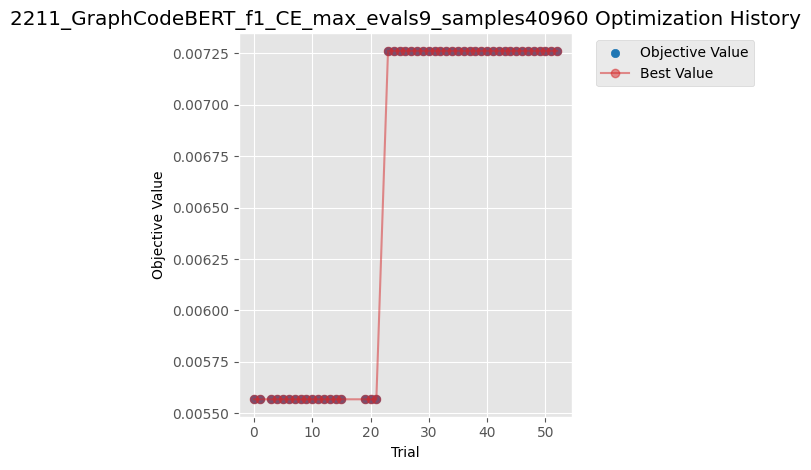

/tmp/ipykernel_84936/1396822593.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


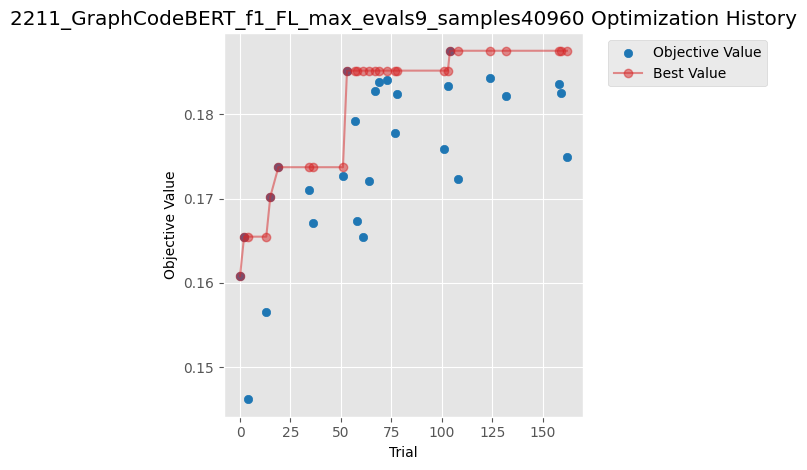

/tmp/ipykernel_84936/1396822593.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


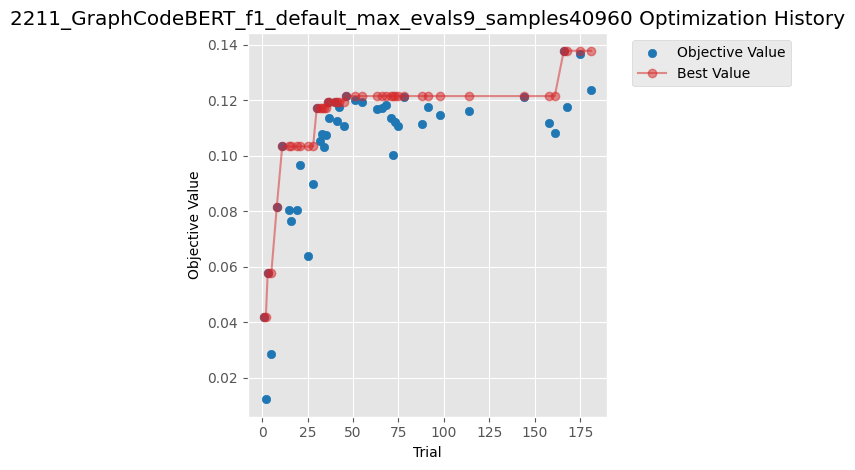

/tmp/ipykernel_84936/1396822593.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


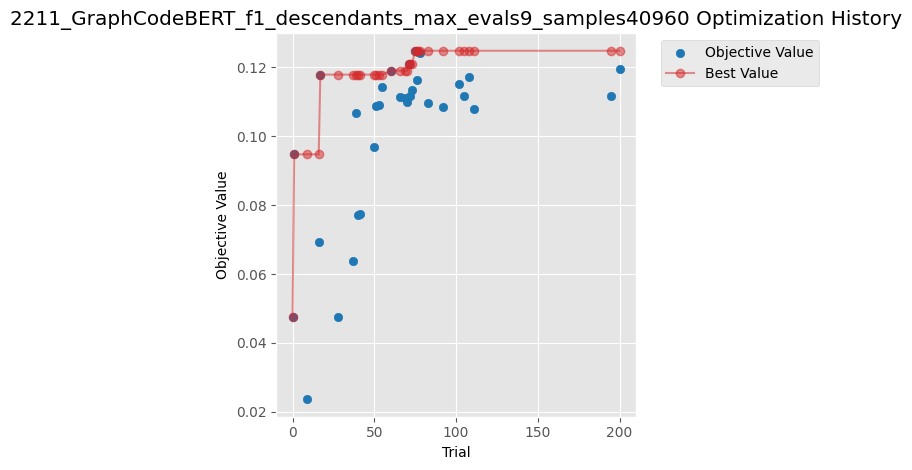

/tmp/ipykernel_84936/1396822593.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


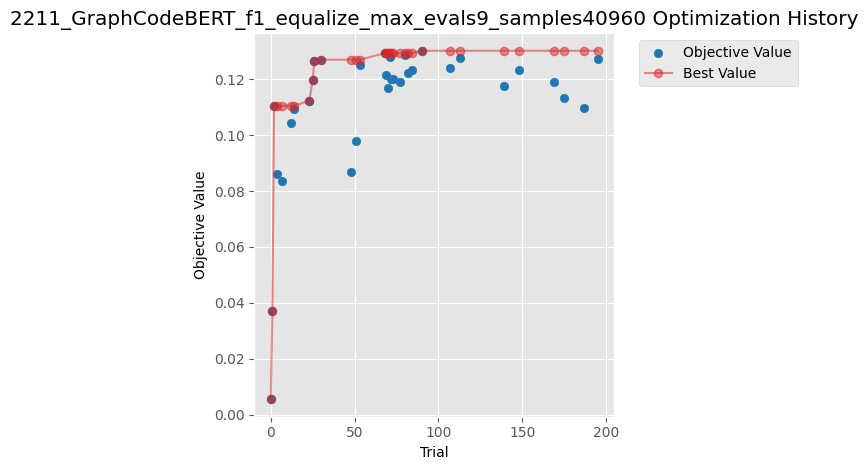

/tmp/ipykernel_84936/1396822593.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


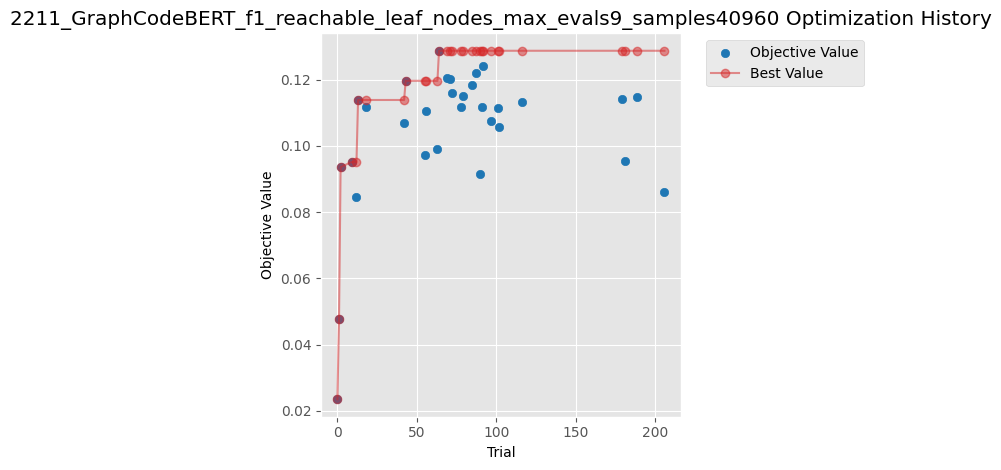

In [13]:
plot_optimization_history(GCB_study_names, GCB_studies)

In [14]:
# plot_param_importances(GCB_study_names, GCB_studies)

/tmp/ipykernel_84936/1396822593.py:11: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_84936/1396822593.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


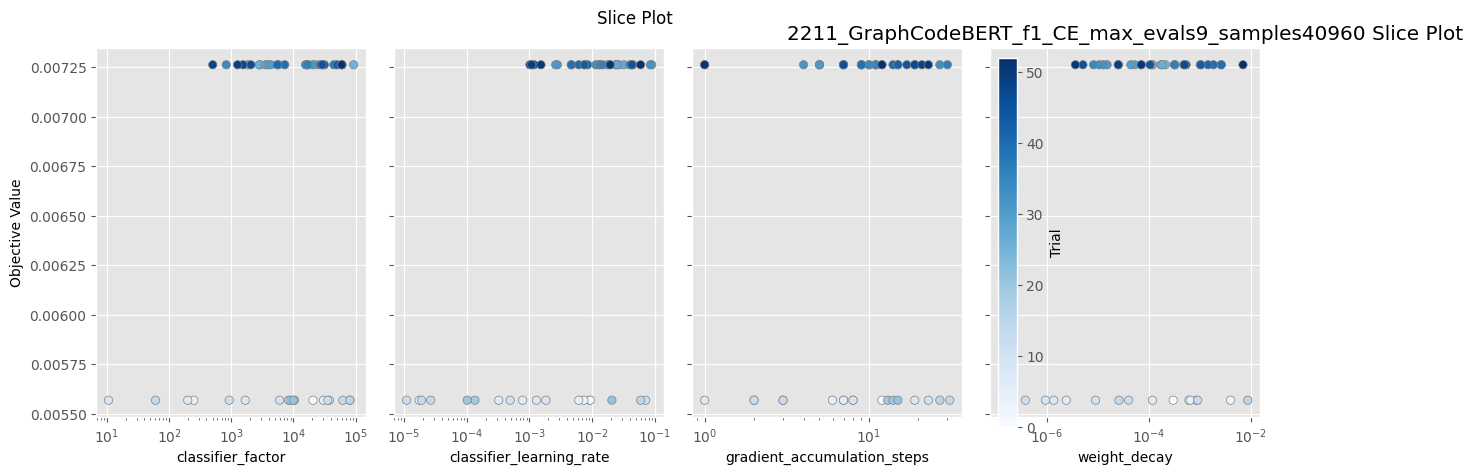

/tmp/ipykernel_84936/1396822593.py:11: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_84936/1396822593.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


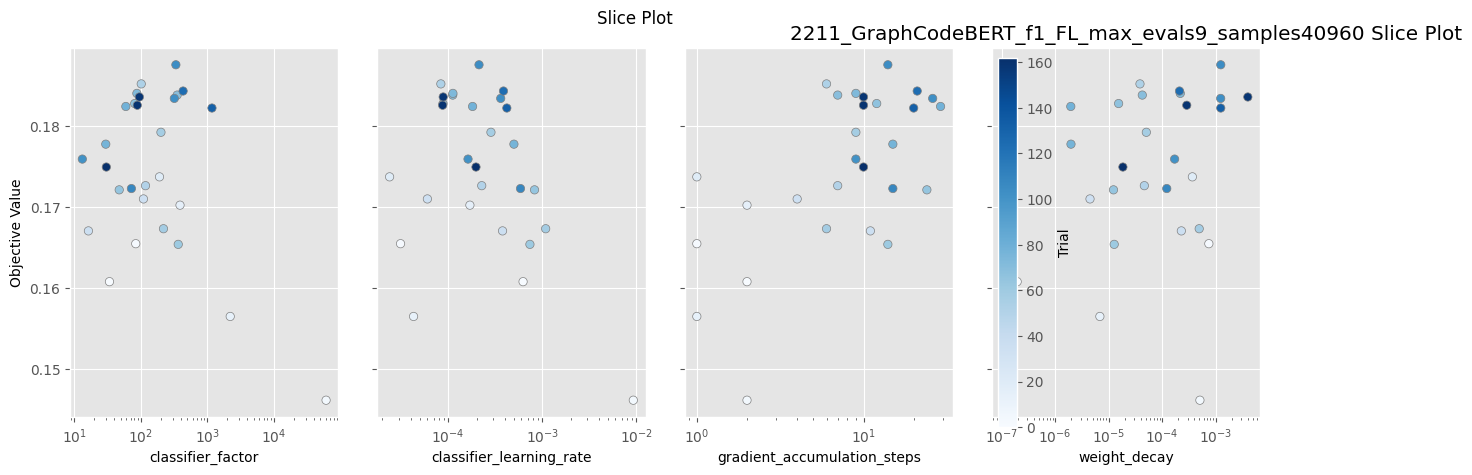

/tmp/ipykernel_84936/1396822593.py:11: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_84936/1396822593.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


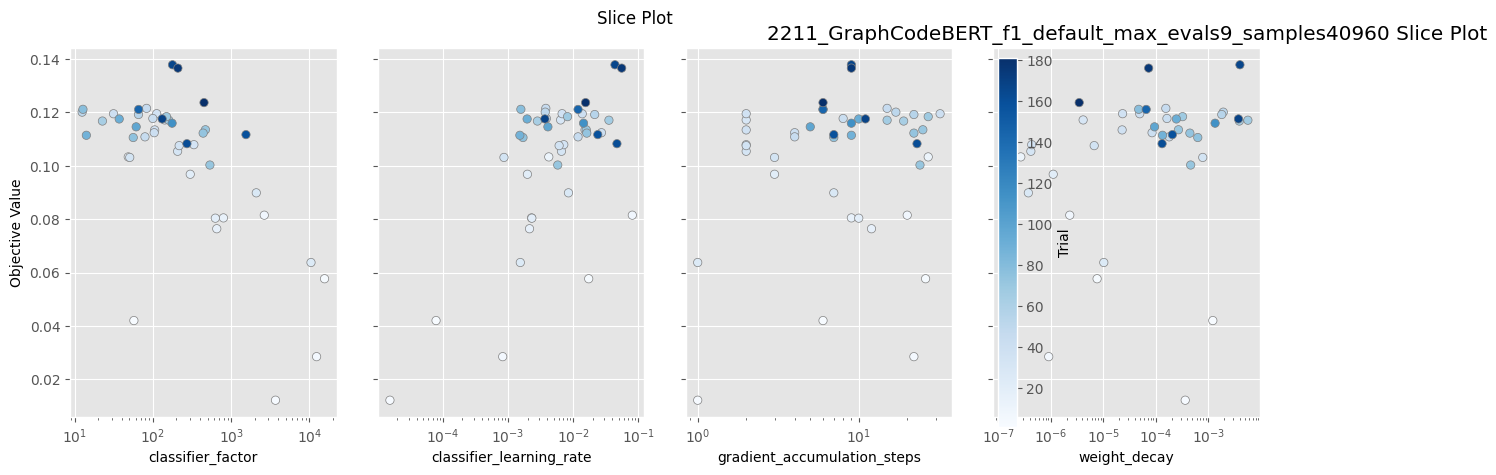

/tmp/ipykernel_84936/1396822593.py:11: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_84936/1396822593.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


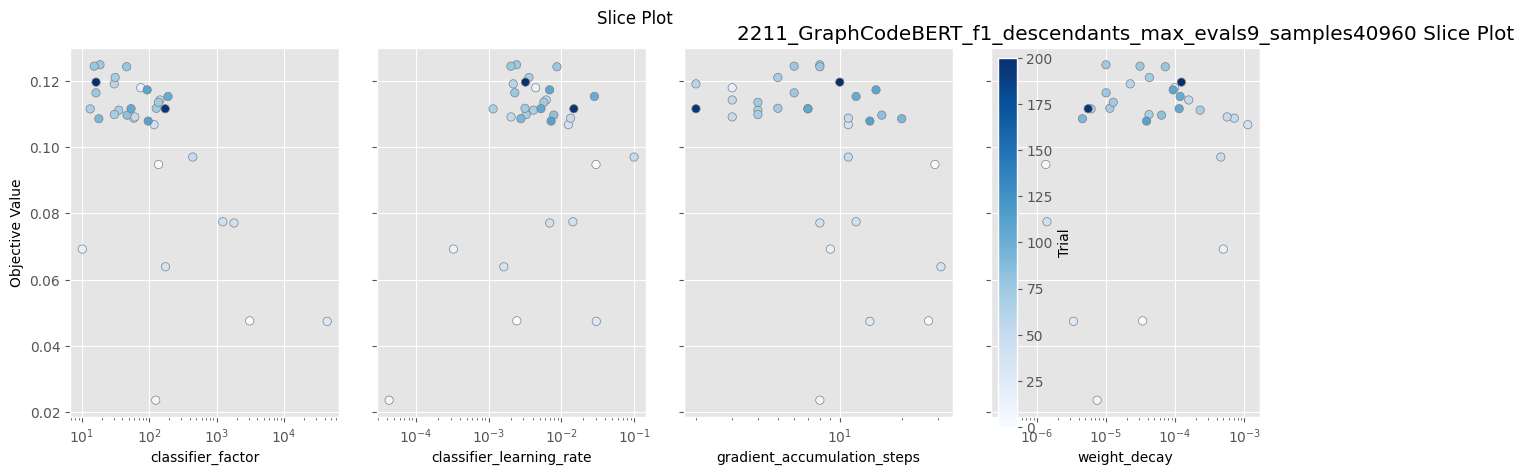

/tmp/ipykernel_84936/1396822593.py:11: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_84936/1396822593.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


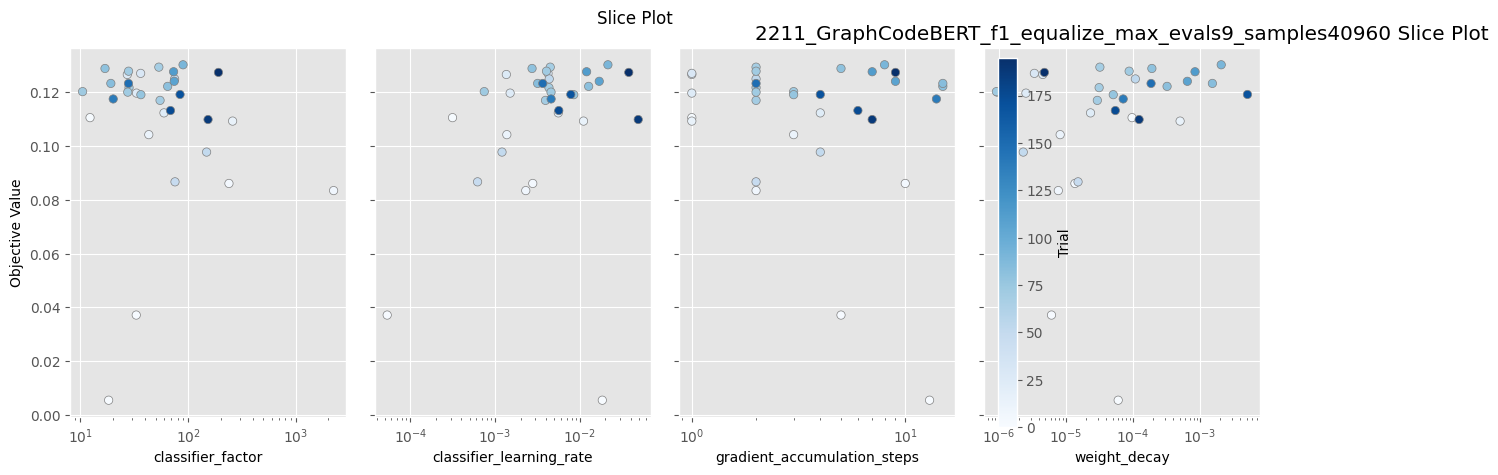

/tmp/ipykernel_84936/1396822593.py:11: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_84936/1396822593.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


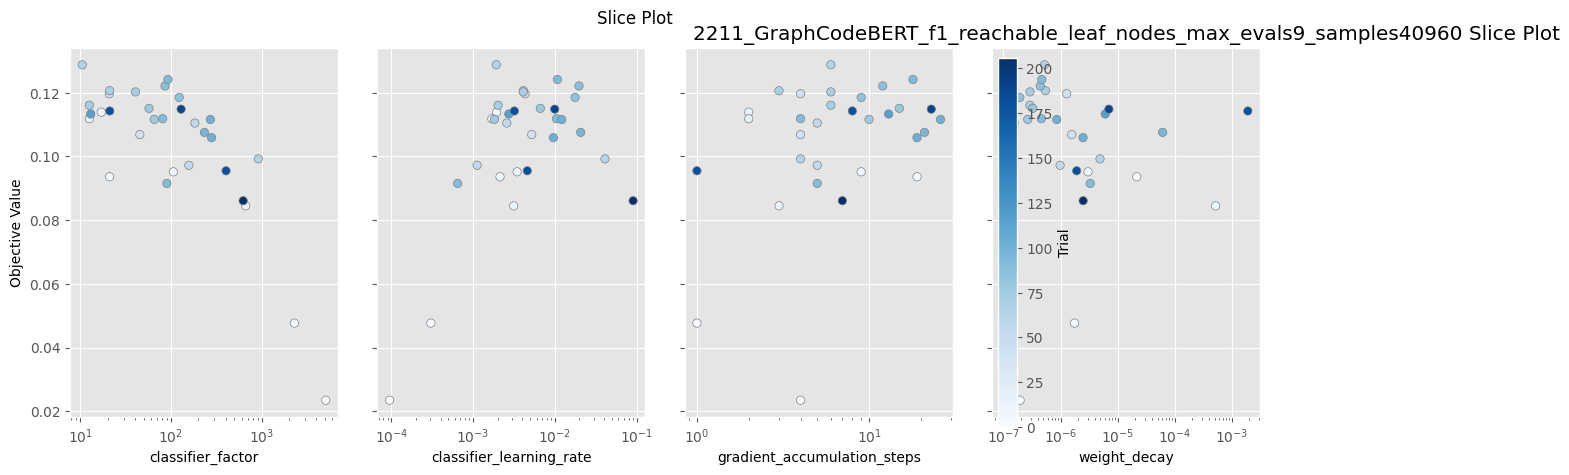

In [15]:
plot_slice(GCB_study_names, GCB_studies)

In [16]:
# plot_values_over_time(GCB_study_names, GCB_studies)

In [17]:
def get_best_params(study_names, studies):
    for i in range(len(studies)):
        print(f"'{study_names[i][5:-24]}' : {studies[i].best_trial.params},")
    
get_best_params(CB_study_names, CB_studies)
get_best_params(GCB_study_names, GCB_studies)

'CodeBERT_f1_CE' : {'classifier_factor': 34.94246723772737, 'classifier_learning_rate': 0.0017927138387849317, 'gradient_accumulation_steps': 3, 'weight_decay': 6.454508964040091e-06},
'CodeBERT_f1_FL' : {'classifier_factor': 2280.8159631117906, 'classifier_learning_rate': 0.0015535525413118611, 'gradient_accumulation_steps': 11, 'weight_decay': 2.2234216113796252e-05},
'CodeBERT_f1_default' : {'classifier_factor': 266.17153286365345, 'classifier_learning_rate': 0.02200212018021276, 'gradient_accumulation_steps': 15, 'weight_decay': 0.003626836244245249},
'CodeBERT_f1_descendants' : {'classifier_factor': 54.76190023283356, 'classifier_learning_rate': 0.004381293858999816, 'gradient_accumulation_steps': 5, 'weight_decay': 8.278245967594842e-07},
'CodeBERT_f1_equalize' : {'classifier_factor': 97.59949745245396, 'classifier_learning_rate': 0.005554065824714457, 'gradient_accumulation_steps': 6, 'weight_decay': 2.5202696599052906e-06},
'CodeBERT_f1_reachable_leaf_nodes' : {'classifier_fact

In [18]:

# data = []
# for trial in studies[0].trials:
#     # Only completed trials will be considered
#     if trial.state == optuna.trial.TrialState.COMPLETE:
# #         print(trial)
#         row = trial.params  # Hyperparameters
#         row["objective_value"] = trial.value  # Performance value
#         row["trial_id"] = trial._trial_id
#         data.append(row)

# # Convert the data to a Pandas DataFrame
# df2 = pd.DataFrame(data)
# df2.isna().sum()

In [19]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import pandas as pd
# from datetime import datetime

# def smooth_values(values, window_size):
#     """Apply a simple moving average smoothing."""
#     return pd.Series(values).rolling(window=window_size, min_periods=1).mean().tolist()

# def plot_values_over_time_with_smoothing(studies, study_names, window_size=3):
#     plt.figure(figsize=(12, 6))
    
#     for study, name in zip(studies, study_names):
#         trial_timestamps = [datetime.fromtimestamp(trial.datetime_start.timestamp()) for trial in study.trials]
#         trial_values = [trial.value for trial in study.trials]
        
#         # Apply smoothing
#         smoothed_values = smooth_values(trial_values, window_size)

#         plt.plot(trial_timestamps, smoothed_values, marker='o', label=name)

#     # Formatting the plot
#     plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
#     plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
#     plt.gcf().autofmt_xdate()  # Rotation

#     plt.title(f"Smoothed Objective Values Over Time Across Studies (Window size: {window_size})")
#     plt.xlabel("Time")
#     plt.ylabel("Smoothed Objective Value")
#     plt.legend()
#     plt.grid()
#     plt.show()

# plot_values_over_time_with_smoothing(studies, study_names,window_size=50)
